In [1]:
# ========================================
# 04_sam_training.ipynb
# SAM (Segment Anything Model) Training
# ========================================

# ----- Cell 1: Mount Google Drive -----
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ----- Cell 2: Setup project paths -----
import os
import sys

PROJECT_ROOT = '/content/drive/MyDrive/SHBT 261/Mini_Project_2'
os.chdir(PROJECT_ROOT)

print(f"Working directory: {os.getcwd()}")
print(f"Project structure:")
!ls -lh

Working directory: /content/drive/MyDrive/SHBT 261/Mini_Project_2
Project structure:
total 1.9M
drwx------ 2 root root 4.0K Nov 15 04:09  data
-rw------- 1 root root 1.9M Nov 15 02:42 'Mini-Project 2.pdf'
drwx------ 2 root root 4.0K Nov 15 04:09  models
drwx------ 2 root root 4.0K Nov 15 04:09  notebooks
drwx------ 2 root root 4.0K Nov 15 04:09  results
-rw------- 1 root root   53 Nov 15 08:45  voc_data_path.txt


In [3]:
# ----- Cell 3: Install SAM and dependencies -----
!pip install -q git+https://github.com/facebookresearch/segment-anything.git
!pip install -q opencv-python
!pip install -q albumentations
!pip install -q kagglehub

print("✓ Dependencies installed")

  Preparing metadata (setup.py) ... done
✓ Dependencies installed


In [4]:
# ----- Cell 4: Download SAM pretrained weights -----
import os
import urllib.request

# Create weights directory
os.makedirs('sam_weights', exist_ok=True)

# Download SAM ViT-B checkpoint
SAM_CHECKPOINT = "sam_weights/sam_vit_b_01ec64.pth"

if not os.path.exists(SAM_CHECKPOINT):
    print("Downloading SAM ViT-B checkpoint...")
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    urllib.request.urlretrieve(url, SAM_CHECKPOINT)
    print(f"✓ Downloaded to {SAM_CHECKPOINT}")
else:
    print(f"✓ Checkpoint already exists: {SAM_CHECKPOINT}")

✓ Downloaded to sam_weights/sam_vit_b_01ec64.pth


In [5]:
# ----- Cell 5: Import libraries -----
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import VOCSegmentation

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import cv2

# Import SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.modeling import Sam

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [6]:
# ----- Cell 6: Load dataset path -----
import kagglehub

print("Loading Pascal VOC 2007 dataset...")
dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

# Find VOC root
trainval_candidates = [
    'VOCtrainval_06-Nov-2007',
    'voctrainval_06-nov-2007',
]

VOC_ROOT = None
for candidate in trainval_candidates:
    candidate_path = os.path.join(dataset_path, candidate)
    if os.path.exists(os.path.join(candidate_path, 'VOCdevkit', 'VOC2007')):
        VOC_ROOT = candidate_path
        break

print(f"✓ VOC_ROOT: {VOC_ROOT}")

# Define classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print(f"✓ Number of classes: {NUM_CLASSES}")

Loading Pascal VOC 2007 dataset...


100%|██████████| 1.65G/1.65G [00:20<00:00, 84.7MB/s]

Extracting files...


✓ VOC_ROOT: /root/.cache/kagglehub/datasets/zaraks/pascal-voc-2007/versions/1/VOCtrainval_06-Nov-2007
✓ Number of classes: 21


In [15]:
# ----- Cell 7: Custom Dataset for SAM (FIXED) -----
from PIL import Image

class VOCDatasetForSAM(Dataset):
    """
    Custom dataset for SAM training
    SAM encoder expects 1024x1024 images
    """
    def __init__(self, root, year, image_set, image_size=1024):  # Changed to 1024
        self.voc = VOCSegmentation(
            root=root,
            year=year,
            image_set=image_set,
            download=False
        )
        self.image_size = image_size

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        image, mask = self.voc[idx]

        # Convert PIL to numpy
        image = np.array(image)
        mask = np.array(mask)

        # Resize to SAM's expected size
        image = cv2.resize(image, (self.image_size, self.image_size))
        mask = cv2.resize(mask, (self.image_size, self.image_size), interpolation=cv2.INTER_NEAREST)

        # Clean mask
        mask[mask == 255] = 0

        # Convert to tensors
        image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask).long()

        return image, image_tensor, mask_tensor

print("✓ Custom dataset class defined")

✓ Custom dataset class defined


In [16]:
# ----- Cell 8: Create datasets and dataloaders (FIXED) -----
IMAGE_SIZE = 1024  # SAM expects 1024x1024

train_dataset = VOCDatasetForSAM(
    root=VOC_ROOT,
    year="2007",
    image_set="train",
    image_size=IMAGE_SIZE
)

val_dataset = VOCDatasetForSAM(
    root=VOC_ROOT,
    year="2007",
    image_set="val",
    image_size=IMAGE_SIZE
)

# Even smaller batch size due to large images
BATCH_SIZE = 1  # Changed from 2 to 1 for safety
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Val samples: {len(val_dataset)}")
print(f"✓ Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")

✓ Train samples: 209
✓ Val samples: 213
✓ Image size: 1024x1024
✓ Batch size: 1
✓ Train batches: 209
✓ Val batches: 213


In [17]:
# ----- Cell 9: Load SAM model and add segmentation head -----
class SAMSegmentationModel(nn.Module):
    """
    SAM model adapted for semantic segmentation
    """
    def __init__(self, sam_checkpoint, num_classes=21):
        super().__init__()

        # Load SAM model
        self.sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)

        # Freeze SAM encoder (optional: can unfreeze for fine-tuning)
        for param in self.sam.image_encoder.parameters():
            param.requires_grad = True  # Allow fine-tuning

        # Add a segmentation head
        # SAM encoder outputs 256 channels
        self.seg_head = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        # x: (B, 3, H, W)
        # Encode image
        features = self.sam.image_encoder(x)  # (B, 256, H/16, W/16)

        # Upsample features and predict
        logits = self.seg_head(features)  # (B, num_classes, H/16, W/16)

        # Upsample to original size
        logits = nn.functional.interpolate(
            logits,
            size=(x.shape[2], x.shape[3]),
            mode='bilinear',
            align_corners=False
        )

        return logits

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAMSegmentationModel(
    sam_checkpoint=SAM_CHECKPOINT,
    num_classes=NUM_CLASSES
).to(device)

print(f"✓ SAM segmentation model created")
print(f"✓ Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

✓ SAM segmentation model created
✓ Device: cuda
✓ Total parameters: 94,106,053
✓ Trainable parameters: 94,106,053


In [18]:
# ----- Cell 10: Define loss and optimizer -----
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - lower learning rate for pretrained model
LEARNING_RATE = 1e-5  # Lower LR for fine-tuning
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

print(f"✓ Loss: CrossEntropyLoss")
print(f"✓ Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"✓ Scheduler: ReduceLROnPlateau")

✓ Loss: CrossEntropyLoss
✓ Optimizer: AdamW (lr=1e-05)
✓ Scheduler: ReduceLROnPlateau


In [19]:
# ----- Cell 11: Define metrics -----
def calculate_iou(pred, target, num_classes=21):
    """Calculate IoU for each class"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())

    return ious

def calculate_pixel_accuracy(pred, target):
    """Calculate pixel-wise accuracy"""
    pred = pred.view(-1)
    target = target.view(-1)
    correct = (pred == target).sum().float()
    total = target.numel()
    return (correct / total).item()

print("✓ Metrics defined")

✓ Metrics defined


In [20]:
# ----- Cell 12: Training function -----
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for images_np, images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward
        loss.backward()
        optimizer.step()

        # Metrics
        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
        batch_acc = calculate_pixel_accuracy(preds, masks)

        running_loss += loss.item()
        running_iou.append(batch_iou)
        running_acc += batch_acc

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{batch_acc:.4f}'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_iou = np.nanmean(running_iou)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_iou, epoch_acc

print("✓ Training function defined")

✓ Training function defined


In [21]:
# ----- Cell 13: Validation function -----
def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images_np, images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            running_loss += loss.item()
            running_iou.append(batch_iou)
            running_acc += batch_acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_acc:.4f}'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_iou = np.nanmean(running_iou)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_iou, epoch_acc

print("✓ Validation function defined")

✓ Validation function defined


In [22]:
# ----- Cell 14: Training loop -----
NUM_EPOCHS = 15  # Fewer epochs for SAM due to time

# Initialize tracking
best_val_iou = 0.0
history = {
    'train_loss': [],
    'train_iou': [],
    'train_acc': [],
    'val_loss': [],
    'val_iou': [],
    'val_acc': [],
}

os.makedirs(f'{PROJECT_ROOT}/models', exist_ok=True)

print("=" * 70)
print(f"Starting SAM Training")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")
print("=" * 70)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_iou, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validate
    val_loss, val_iou, val_acc = validate(
        model, val_loader, criterion, device
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_acc'].append(val_acc)

    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'val_loss': val_loss,
        }, f'{PROJECT_ROOT}/models/sam_best.pth')
        print(f"  ✓ Best model saved! (IoU: {val_iou:.4f})")

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f'{PROJECT_ROOT}/models/sam_checkpoint_epoch_{epoch+1}.pth')
        print(f"  ✓ Checkpoint saved at epoch {epoch+1}")

end_time = time.time()
training_time = end_time - start_time

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Best validation IoU: {best_val_iou:.4f}")

Starting SAM Training
Epochs: 15
Device: cuda

Epoch 1/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.22it/s, loss=2.7219, acc=0.3043]



Epoch 1 Summary:
  Train Loss: 2.7985 | Train IoU: 0.0265 | Train Acc: 0.3587
  Val Loss:   2.7476 | Val IoU:   0.0361 | Val Acc:   0.4651
  ✓ Best model saved! (IoU: 0.0361)

Epoch 2/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, loss=2.6821, acc=0.2007]



Epoch 2 Summary:
  Train Loss: 2.5180 | Train IoU: 0.0425 | Train Acc: 0.5420
  Val Loss:   2.3832 | Val IoU:   0.0541 | Val Acc:   0.5980
  ✓ Best model saved! (IoU: 0.0541)

Epoch 3/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, loss=2.7470, acc=0.1935]



Epoch 3 Summary:
  Train Loss: 2.3588 | Train IoU: 0.0530 | Train Acc: 0.5691
  Val Loss:   2.1888 | Val IoU:   0.0668 | Val Acc:   0.6487
  ✓ Best model saved! (IoU: 0.0668)

Epoch 4/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.7474, acc=0.2046]



Epoch 4 Summary:
  Train Loss: 2.2507 | Train IoU: 0.0636 | Train Acc: 0.6093
  Val Loss:   2.1603 | Val IoU:   0.0631 | Val Acc:   0.6407

Epoch 5/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, loss=2.7865, acc=0.1975]



Epoch 5 Summary:
  Train Loss: 2.1541 | Train IoU: 0.0699 | Train Acc: 0.6377
  Val Loss:   2.2069 | Val IoU:   0.0629 | Val Acc:   0.5752
  ✓ Checkpoint saved at epoch 5

Epoch 6/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, loss=2.7772, acc=0.1984]



Epoch 6 Summary:
  Train Loss: 2.0662 | Train IoU: 0.0753 | Train Acc: 0.6591
  Val Loss:   1.8662 | Val IoU:   0.0753 | Val Acc:   0.6982
  ✓ Best model saved! (IoU: 0.0753)

Epoch 7/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, loss=2.8130, acc=0.1985]



Epoch 7 Summary:
  Train Loss: 1.9818 | Train IoU: 0.0807 | Train Acc: 0.6771
  Val Loss:   1.8486 | Val IoU:   0.0737 | Val Acc:   0.7109

Epoch 8/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.7983, acc=0.1981]



Epoch 8 Summary:
  Train Loss: 1.9092 | Train IoU: 0.0824 | Train Acc: 0.6923
  Val Loss:   1.9284 | Val IoU:   0.0821 | Val Acc:   0.6618
  ✓ Best model saved! (IoU: 0.0821)

Epoch 9/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.6421, acc=0.2485]



Epoch 9 Summary:
  Train Loss: 1.8441 | Train IoU: 0.0853 | Train Acc: 0.7049
  Val Loss:   1.8895 | Val IoU:   0.0774 | Val Acc:   0.6341

Epoch 10/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.8063, acc=0.1979]



Epoch 10 Summary:
  Train Loss: 1.7737 | Train IoU: 0.0915 | Train Acc: 0.7193
  Val Loss:   1.8696 | Val IoU:   0.0899 | Val Acc:   0.6478
  ✓ Best model saved! (IoU: 0.0899)
  ✓ Checkpoint saved at epoch 10

Epoch 11/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.8361, acc=0.1982]



Epoch 11 Summary:
  Train Loss: 1.7144 | Train IoU: 0.0949 | Train Acc: 0.7323
  Val Loss:   1.7311 | Val IoU:   0.0908 | Val Acc:   0.7177
  ✓ Best model saved! (IoU: 0.0908)

Epoch 12/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.6574, acc=0.2376]



Epoch 12 Summary:
  Train Loss: 1.6596 | Train IoU: 0.0950 | Train Acc: 0.7549
  Val Loss:   1.6654 | Val IoU:   0.0914 | Val Acc:   0.7445
  ✓ Best model saved! (IoU: 0.0914)

Epoch 13/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, loss=2.8568, acc=0.1982]



Epoch 13 Summary:
  Train Loss: 1.6201 | Train IoU: 0.0994 | Train Acc: 0.7665
  Val Loss:   1.6822 | Val IoU:   0.0925 | Val Acc:   0.7422
  ✓ Best model saved! (IoU: 0.0925)

Epoch 14/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=2.8796, acc=0.1987]



Epoch 14 Summary:
  Train Loss: 1.5537 | Train IoU: 0.1071 | Train Acc: 0.7908
  Val Loss:   1.5336 | Val IoU:   0.1153 | Val Acc:   0.7651
  ✓ Best model saved! (IoU: 0.1153)

Epoch 15/15
----------------------------------------------------------------------


Validation: 100%|██████████| 213/213 [01:36<00:00,  2.20it/s, loss=3.0583, acc=0.1992]



Epoch 15 Summary:
  Train Loss: 1.4835 | Train IoU: 0.1122 | Train Acc: 0.8116
  Val Loss:   1.3940 | Val IoU:   0.1184 | Val Acc:   0.7888
  ✓ Best model saved! (IoU: 0.1184)
  ✓ Checkpoint saved at epoch 15

TRAINING COMPLETE!
Total training time: 91.27 minutes
Best validation IoU: 0.1184


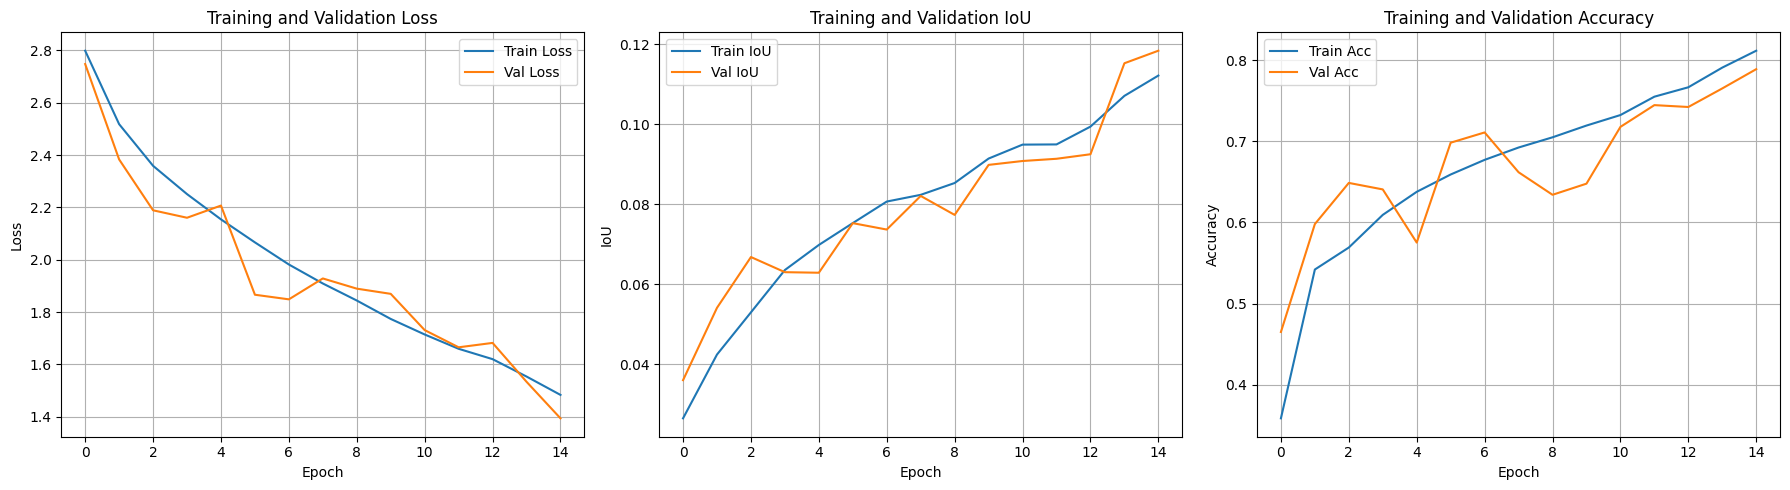

✓ Training history saved


In [23]:
# ----- Cell 15: Plot training history -----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_iou'], label='Train IoU')
axes[1].plot(history['val_iou'], label='Val IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training and Validation IoU')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history['train_acc'], label='Train Acc')
axes[2].plot(history['val_acc'], label='Val Acc')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training and Validation Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/sam_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history saved")

In [24]:
# ----- Cell 16: Save final model -----
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'best_val_iou': best_val_iou,
    'training_time': training_time,
}, f'{PROJECT_ROOT}/models/sam_final.pth')

print(f"✓ Final model saved")

✓ Final model saved


In [25]:
# ----- Cell 17: Load best model -----
checkpoint = torch.load(f'{PROJECT_ROOT}/models/sam_best.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Best model loaded (from epoch {checkpoint['epoch']+1})")
print(f"  Validation IoU: {checkpoint['val_iou']:.4f}")

✓ Best model loaded (from epoch 15)
  Validation IoU: 0.1184


In [26]:
# ----- Cell 18: Visualize predictions -----
def visualize_sam_predictions(model, dataset, device, num_samples=5, save_dir=None):
    """Visualize SAM predictions"""
    model.eval()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            image_np, image, mask = dataset[idx]

            image_input = image.unsqueeze(0).to(device)
            output = model(image_input)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            mask_gt = mask.cpu().numpy()

            # Plot
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_gt, cmap='tab20', vmin=0, vmax=20)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred, cmap='tab20', vmin=0, vmax=20)
            axes[i, 2].set_title('SAM Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'sam_predictions.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved to: {save_path}")

    plt.show()

print("Visualizing SAM predictions...")
visualize_sam_predictions(
    model,
    val_dataset,
    device,
    num_samples=5,
    save_dir=f'{PROJECT_ROOT}/results'
)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
# ----- Cell 19: Evaluate on validation set -----
def evaluate_sam(model, dataloader, device, num_classes=21):
    """Comprehensive evaluation"""
    model.eval()

    all_ious = []
    all_accs = []
    class_ious = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images_np, images, masks in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            batch_iou = calculate_iou(preds, masks, num_classes)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            all_ious.append(batch_iou)
            all_accs.append(batch_acc)

            for cls in range(num_classes):
                if not np.isnan(batch_iou[cls]):
                    class_ious[cls].append(batch_iou[cls])

    mean_iou = np.nanmean(all_ious)
    mean_acc = np.mean(all_accs)
    per_class_iou = [np.mean(ious) if len(ious) > 0 else 0.0 for ious in class_ious]

    return mean_iou, mean_acc, per_class_iou

print("Evaluating SAM on validation set...")
val_iou, val_acc, per_class_iou = evaluate_sam(model, val_loader, device)

print("\n" + "=" * 70)
print("FINAL SAM VALIDATION METRICS")
print("=" * 70)
print(f"Mean IoU: {val_iou:.4f}")
print(f"Pixel Accuracy: {val_acc:.4f}")
print("\nPer-class IoU:")
print("-" * 70)
for idx, iou in enumerate(per_class_iou):
    print(f"  {idx:2d}. {VOC_CLASSES[idx]:15s}: {iou:.4f}")
print("=" * 70)

Evaluating SAM on validation set...


Evaluating: 100%|██████████| 213/213 [01:37<00:00,  2.19it/s]


FINAL SAM VALIDATION METRICS
Mean IoU: 0.1184
Pixel Accuracy: 0.7888

Per-class IoU:
----------------------------------------------------------------------
   0. background     : 0.8570
   1. aeroplane      : 0.0020
   2. bicycle        : 0.0003
   3. bird           : 0.0000
   4. boat           : 0.0000
   5. bottle         : 0.0022
   6. bus            : 0.0213
   7. car            : 0.0346
   8. cat            : 0.0416
   9. chair          : 0.0070
  10. cow            : 0.0014
  11. diningtable    : 0.0316
  12. dog            : 0.0140
  13. horse          : 0.0406
  14. motorbike      : 0.0437
  15. person         : 0.4161
  16. pottedplant    : 0.0004
  17. sheep          : 0.0043
  18. sofa           : 0.0029
  19. train          : 0.0092
  20. tvmonitor      : 0.0407


In [28]:
# ----- Cell 20: Save summary -----
import json

summary = {
    'model': 'SAM',
    'encoder': 'ViT-B',
    'pretrained': True,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'optimizer': 'AdamW',
    'loss_function': 'CrossEntropyLoss',
    'training_time_minutes': training_time / 60,
    'best_val_iou': float(best_val_iou),
    'final_val_iou': float(val_iou),
    'final_val_acc': float(val_acc),
    'num_parameters': trainable_params,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
}

summary_path = f'{PROJECT_ROOT}/results/sam_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("=" * 70)
print("SAM TRAINING SUMMARY")
print("=" * 70)
for key, value in summary.items():
    print(f"{key:25s}: {value}")
print("=" * 70)
print(f"\n✓ Summary saved to: {summary_path}")

SAM TRAINING SUMMARY
model                    : SAM
encoder                  : ViT-B
pretrained               : True
num_epochs               : 15
batch_size               : 1
learning_rate            : 1e-05
optimizer                : AdamW
loss_function            : CrossEntropyLoss
training_time_minutes    : 91.27478042840957
best_val_iou             : 0.1184035684154866
final_val_iou            : 0.1184035684154866
final_val_acc            : 0.7888213905370292
num_parameters           : 94106053
train_samples            : 209
val_samples              : 213

✓ Summary saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/sam_summary.json
